# Comparison of Classifiers

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Train-Test Split
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# For model evaulation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

In [2]:
df = pd.read_csv("SUV_Purchase.csv")
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


In [4]:
# Class Names
class_names = {'Not Purchased':0, 'Purchased':1}
# Remove User ID
df.drop('User ID', axis = 1, inplace = True)
# Encoding Gender
df.replace({'Male':1, 'Female':0}, inplace = True)

df.head()

,Gender,Age,EstimatedSalary,Purchased
0,1,19,19000,0
1,1,35,20000,0
2,0,26,43000,0
3,0,27,57000,0
4,1,19,76000,0


In [5]:
sc = StandardScaler()
df[['Age','EstimatedSalary']] = sc.fit_transform(df.loc[:, ['Age','EstimatedSalary']])
df.head()

,Gender,Age,EstimatedSalary,Purchased
0,1,-1.781797,-1.490046,0
1,1,-0.253587,-1.460681,0
2,0,-1.113206,-0.785290,0
3,0,-1.017692,-0.374182,0
4,1,-1.781797,0.183751,0


In [6]:
# variable Separation
X = df.drop('Purchased', axis = 1).values
y = df.loc[:, 'Purchased'].values
# Train test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# results
print("X_train: ",np.shape(X_train))
print("y_train: ",np.shape(y_train))
print('X_test:',np.shape(X_test))
print('y_test:',np.shape(y_test))

X_train:  (320, 3)
y_train:  (320,)
X_test: (80, 3)
y_test: (80,)


In [8]:
# PCA for dimensionality reduction
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
## results of 
print('Variance Captured by PCA')
for i in np.arange(pca.n_components_):
    print("PC{0:d}: {1:.1f}%".format(i+1, 100*pca.explained_variance_ratio_[i]))

Variance Captured by PCA
PC1: 56.8%
PC2: 43.2%


In [9]:
def AUC_ROC(model,X_train, X_test, y_train, y_test) :
    # Training Data
    y_train_prob = model.predict_proba(X_train)
    fpr1, tpr1, thres1 = roc_curve(y_train, y_train_prob[:,1], pos_label = 1)
    auc1 = auc(fpr1, tpr1)
    # testing Data
    y_test_prob = model.predict_proba(X_test)
    fpr2, tpr2, thres2 = roc_curve(y_test, y_test_prob[:,1], pos_label = 1)
    auc2= auc(fpr2, tpr2)
    #plotting
    plt.figure(figsize = (8,6))
    plt.plot(fpr1, tpr1, label = "Training: AUC-ROC = {0:.3f}".format(auc1),
             color = "tab:orange")
    plt.plot(fpr2, tpr2, label = "Testing: AUC-ROC = {0:.3f}".format(auc2),
             color = 'tab:blue')
    plt.plot(fpr1, fpr1, label = "FPR = TPR", color = 'black', linewidth=0.5)
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title("ROC Curve for " + model.__class__.__name__)
    plt.legend(loc = "lower right")
    plt.grid(which = 'both', axis = 'both')
    plt.show()
    pass

In [10]:
def cm_Heatmap(y_true, y_pred, class_name = np.unique(y_train)) :
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    cm = pd.DataFrame(cm, columns = class_name, index = class_name)
    # Plotting
    plt.figure(figsize = (8,6))
    sns.heatmap(cm, annot = True, annot_kws = {'size': 20}, fmt = 'd', cmap = 'Greens')
    plt.xlabel('Observed Class')
    plt.ylabel('Predicted Class')
    plt.title('Confusion Matrix')
    plt.show()
    pass

In [12]:
# Training the Model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
# Training Reprto
print(classification_report(y_train, log_reg.predict(X_train), target_names = class_names))

               precision    recall  f1-score   support

Not Purchased       0.86      0.91      0.88       205
    Purchased       0.82      0.73      0.77       115

     accuracy                           0.85       320
    macro avg       0.84      0.82      0.83       320
 weighted avg       0.85      0.85      0.84       320



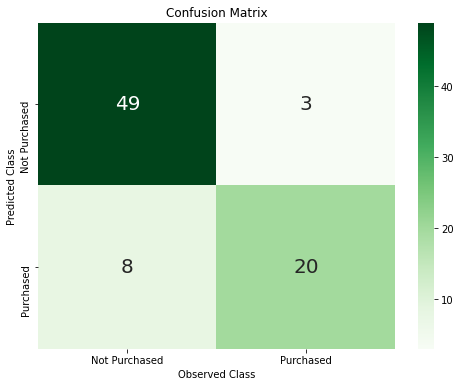

In [13]:
# test data
cm_Heatmap(y_test, log_reg.predict(X_test), class_names)

In [14]:
# Classification report
print(classification_report(y_test, log_reg.predict(X_test), target_names = class_names))

               precision    recall  f1-score   support

Not Purchased       0.86      0.94      0.90        52
    Purchased       0.87      0.71      0.78        28

     accuracy                           0.86        80
    macro avg       0.86      0.83      0.84        80
 weighted avg       0.86      0.86      0.86        80



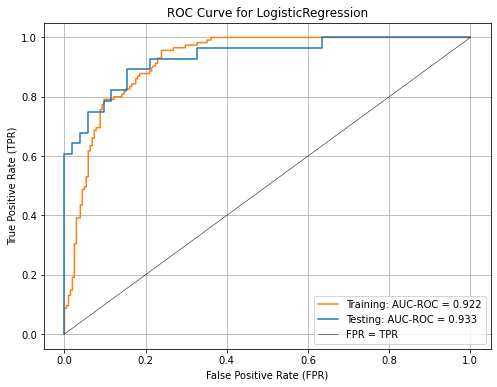

In [15]:
AUC_ROC(log_reg, X_train, X_test, y_train, y_test)

In [16]:
# Training model
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
# Training report
print(classification_report(y_train, knn.predict(X_train), target_names = class_names))

               precision    recall  f1-score   support

Not Purchased       0.95      0.93      0.94       205
    Purchased       0.88      0.91      0.89       115

     accuracy                           0.92       320
    macro avg       0.91      0.92      0.92       320
 weighted avg       0.92      0.92      0.92       320



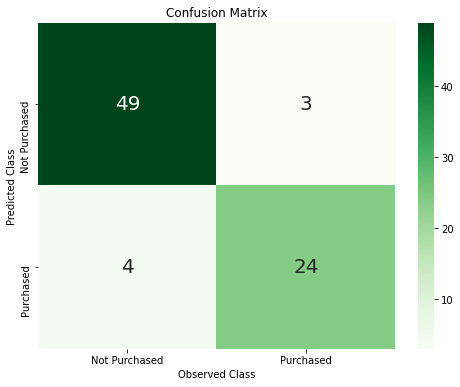

In [17]:
cm_Heatmap(y_test, knn.predict(X_test), class_names)

In [18]:
print(classification_report(y_test, knn.predict(X_test), target_names = class_names))

               precision    recall  f1-score   support

Not Purchased       0.92      0.94      0.93        52
    Purchased       0.89      0.86      0.87        28

     accuracy                           0.91        80
    macro avg       0.91      0.90      0.90        80
 weighted avg       0.91      0.91      0.91        80



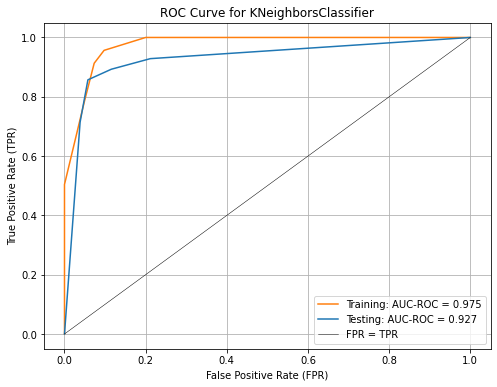

In [19]:
AUC_ROC(knn, X_train, X_test, y_train, y_test)

In [20]:
# Training model
dtc = DecisionTreeClassifier(max_depth = 4)
dtc.fit(X_train, y_train)
## Trainign report
print(classification_report(y_train, dtc.predict(X_train), target_names = class_names))

               precision    recall  f1-score   support

Not Purchased       0.94      0.95      0.95       205
    Purchased       0.91      0.90      0.90       115

     accuracy                           0.93       320
    macro avg       0.93      0.92      0.93       320
 weighted avg       0.93      0.93      0.93       320



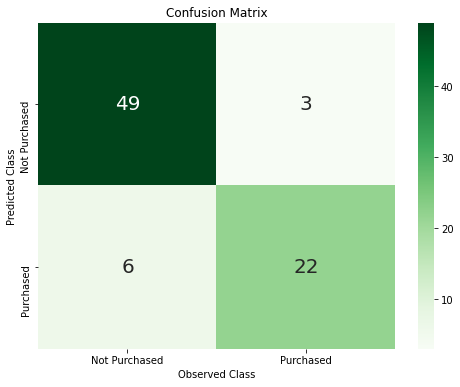

In [21]:
# test data
cm_Heatmap(y_test, dtc.predict(X_test), class_names)

In [22]:
# Classification report
print(classification_report(y_test, dtc.predict(X_test), target_names = class_names))

               precision    recall  f1-score   support

Not Purchased       0.89      0.94      0.92        52
    Purchased       0.88      0.79      0.83        28

     accuracy                           0.89        80
    macro avg       0.89      0.86      0.87        80
 weighted avg       0.89      0.89      0.89        80



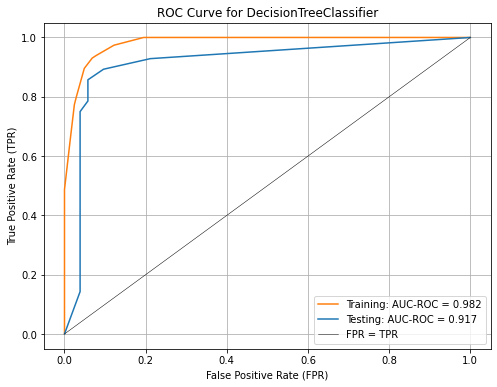

In [23]:
AUC_ROC(dtc, X_train, X_test, y_train, y_test)

In [24]:
# Training model
rfc = RandomForestClassifier(n_estimators = 50, max_depth = 3)
rfc.fit(X_train, y_train)
# Training report
print(classification_report(y_train, rfc.predict(X_train), target_names = class_names))

               precision    recall  f1-score   support

Not Purchased       0.96      0.91      0.94       205
    Purchased       0.86      0.94      0.90       115

     accuracy                           0.92       320
    macro avg       0.91      0.93      0.92       320
 weighted avg       0.93      0.92      0.92       320



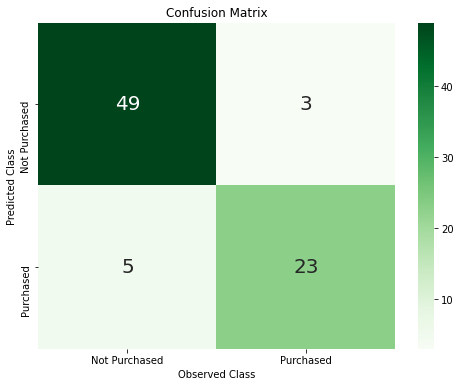

In [25]:
cm_Heatmap(y_test, rfc.predict(X_test), class_names)

In [27]:
print(classification_report(y_test, rfc.predict(X_test), target_names = class_names))

               precision    recall  f1-score   support

Not Purchased       0.91      0.94      0.92        52
    Purchased       0.88      0.82      0.85        28

     accuracy                           0.90        80
    macro avg       0.90      0.88      0.89        80
 weighted avg       0.90      0.90      0.90        80



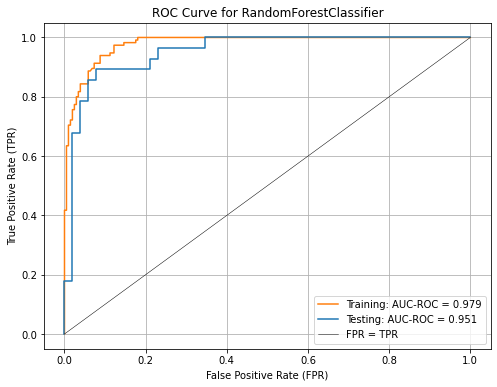

In [29]:
AUC_ROC(rfc, X_train, X_test, y_train, y_test)

In [30]:
# Training model
nbc = GaussianNB(priors = np.array([0.5, 0.5]))
nbc.fit(X_train, y_train)
# Training report
print(classification_report(y_train, nbc.predict(X_train), target_names = class_names))

               precision    recall  f1-score   support

Not Purchased       0.96      0.88      0.92       205
    Purchased       0.82      0.94      0.87       115

     accuracy                           0.90       320
    macro avg       0.89      0.91      0.90       320
 weighted avg       0.91      0.90      0.90       320



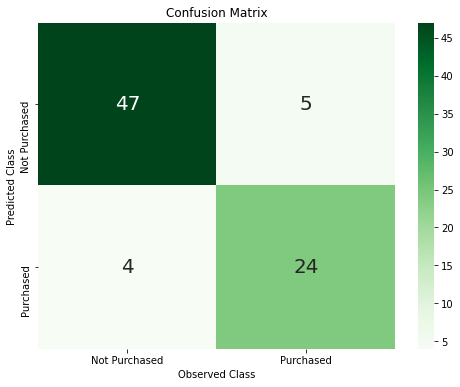

In [31]:
cm_Heatmap(y_test, nbc.predict(X_test), class_names)

In [32]:
print(classification_report(y_test, nbc.predict(X_test), target_names = class_names))

               precision    recall  f1-score   support

Not Purchased       0.92      0.90      0.91        52
    Purchased       0.83      0.86      0.84        28

     accuracy                           0.89        80
    macro avg       0.87      0.88      0.88        80
 weighted avg       0.89      0.89      0.89        80



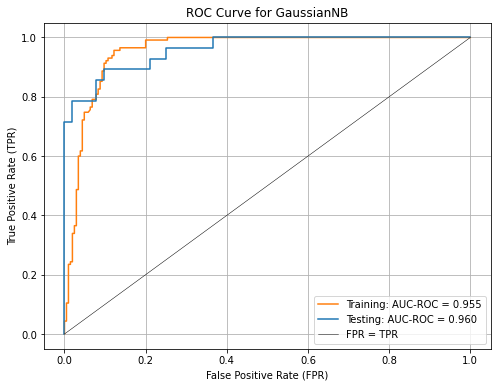

In [33]:
AUC_ROC(nbc, X_train, X_test, y_train, y_test)